In [21]:
from copy import deepcopy
import pandas as pd
from pandas import Series, DataFrame
import re
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Q1 Create a unique name for each restaurant:

In [22]:
#loading the database in df
df = pd.read_csv('NYC_Restaurants.csv', dtype = str)

In [23]:
#creating restaurant by combining DBA, BUILDING, STREET, ZIPCODE AND BORO; printing the first 10 values
df['RESTAURANT'] = df['DBA'] + " " + df['BUILDING'] + " " + df['STREET'] + " " + df['ZIPCODE'] + " " + df['BORO']
df['RESTAURANT'][0:10]

0           WENDY'S 469 FLATBUSH AVENUE 11225 BROOKLYN
1           WENDY'S 469 FLATBUSH AVENUE 11225 BROOKLYN
2           WENDY'S 469 FLATBUSH AVENUE 11225 BROOKLYN
3           WENDY'S 469 FLATBUSH AVENUE 11225 BROOKLYN
4           WENDY'S 469 FLATBUSH AVENUE 11225 BROOKLYN
5        TOV KOSHER KITCHEN 97-22 63 ROAD 11374 QUEENS
6        TOV KOSHER KITCHEN 97-22 63 ROAD 11374 QUEENS
7        TOV KOSHER KITCHEN 97-22 63 ROAD 11374 QUEENS
8        TOV KOSHER KITCHEN 97-22 63 ROAD 11374 QUEENS
9    BRUNOS ON THE BOULEVARD 8825 ASTORIA BOULEVARD...
Name: RESTAURANT, dtype: object

# Q2 How many restaurants are included in the data?

In [24]:
#finding unique number of restaurants in the data
len(df['RESTAURANT'].unique())

10114

# Q3 How many chains are there?

In [25]:
#finding count of DBA with more than 1 restaurant
restaurant_count = df[['DBA', 'RESTAURANT']].dropna(how = 'any').drop_duplicates()['DBA'].value_counts()
len(restaurant_count[restaurant_count.values > 1])

368

# Q4 Plot a bar graph of the top 20 most popular chains

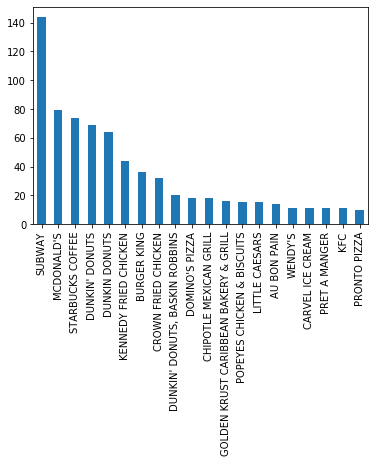

In [26]:
#counting no. of restaurants for each chain as a measure for popularity and plotting top 20 most popular chains
restaurant_count[:20].plot(kind = 'bar')

# Q5 What fraction of all restaurants are chain restaurants?

In [27]:
#finding fraction of chain restaurants out of total restaurants
sum(restaurant_count[restaurant_count>1])/sum(restaurant_count)

0.16472216729286138

# Q6 Plot the number of non-chain restaurants in each boro

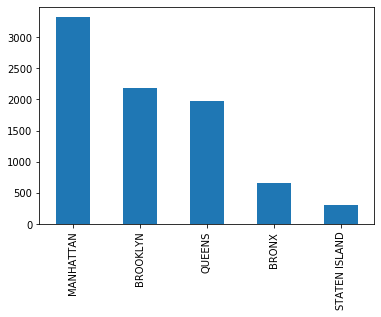

In [28]:
#converting 'Missing' boro to NAs
df.loc[df['BORO'] == "Missing", 'BORO'] = np.nan

#creating deep copy of NYC data for further manipulation
nonchain = deepcopy(df)

#merging the data with DBA vs restaurant count to get no. of restaurants for a DBA in DBA_count
mergednonchain = nonchain.merge(DataFrame(restaurant_count.reset_index()), left_on = 'DBA', right_on = 'index', suffixes = ['_name', '_count'])

#plotting the nonchain restaurants for each BORO
mergednonchain[mergednonchain['DBA_count'] == 1][['BORO', 'RESTAURANT']].drop_duplicates()['BORO'].value_counts().plot(kind = "bar")

# Q7 Plot the fraction of non-chain restaurants in each boro

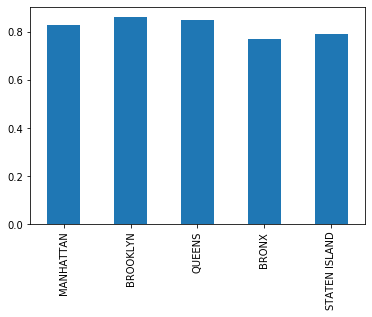

In [29]:
#Ratio of non chain restaurants to total restaurants per boro
(mergednonchain[mergednonchain['DBA_count'] == 1][['BORO', 'RESTAURANT']].drop_duplicates()['BORO'].value_counts()/mergednonchain[['BORO', 'RESTAURANT']].drop_duplicates()['BORO'].value_counts()).plot(kind = "bar")

No, the boro with the most independent restaurants, i.e. Manhattan, is not the one with the highest ratio of independent restaurants. Brooklyn has the highest ratio.

# Q8 Plot the popularity of cuisines

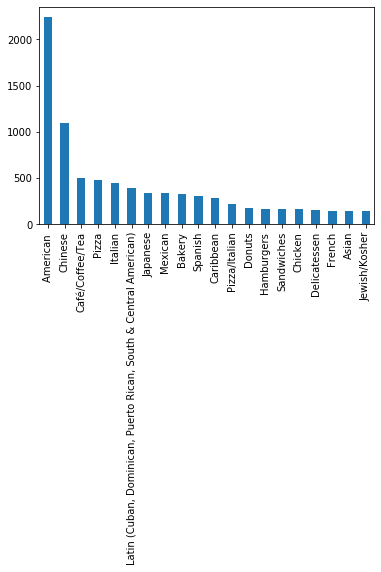

In [30]:
#plotting popularity of top 20 cuisines,i.e. no of restaurants serving that cuisine
df[['CUISINE DESCRIPTION','RESTAURANT']].dropna(how = 'any').drop_duplicates()['CUISINE DESCRIPTION'].value_counts()[:20].plot(kind = 'bar')

# Q9 Plot the cuisines among restaurants which never got cited for violations

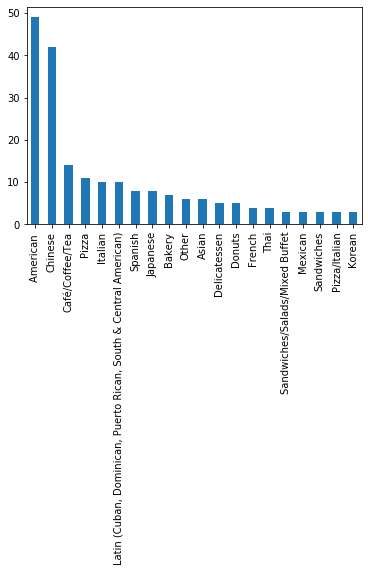

In [31]:
#defining a function to return 0 in case there's no violation code
def if_violationcode_null(violation_code):
    if pd.isnull(violation_code):
        return 0
    else:
        return 1

#creating a column to check whether associated violation is code is null, if null returns 0
df['ViolationCodeNull'] = df['VIOLATION CODE'].map(if_violationcode_null)

#checking which restaurants never got a violation code
restaurant_citations = df.groupby(['RESTAURANT'])['ViolationCodeNull'].sum()
non_cited_restaurants = restaurant_citations[restaurant_citations == 0].index
non_cited_restaurants

#plotting 20 most popular cuisines based on no. of non cited restaurants they're available in
df[df['RESTAURANT'].isin(non_cited_restaurants)][['CUISINE DESCRIPTION','RESTAURANT']].dropna(how = 'any').drop_duplicates()['CUISINE DESCRIPTION'].value_counts()[:20].plot(kind = 'bar')

# Q10 What cuisines tend to be the "cleanest"?

Soul Food                        0.090909
Vietnamese/Cambodian/Malaysia    0.062500
Other                            0.058252
Soups & Sandwiches               0.047619
Continental                      0.047619
Barbecue                         0.047619
Asian                            0.041096
Chinese                          0.038251
Greek                            0.036364
Peruvian                         0.035714
Name: CUISINE DESCRIPTION, dtype: float64 AxesSubplot(0.125,0.125;0.775x0.755)


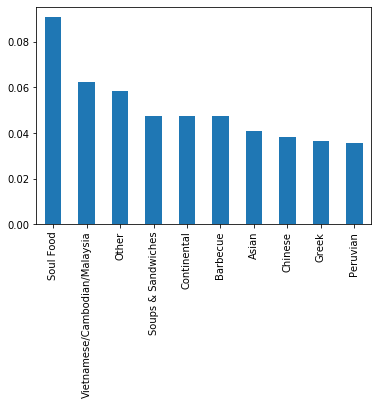

In [32]:
#Getting cuisine popularity wrt all restaurants
cuisine_restaurantcount = df[['CUISINE DESCRIPTION','RESTAURANT']].dropna(how = 'any').drop_duplicates()['CUISINE DESCRIPTION'].value_counts()
popularcuisines = cuisine_restaurantcount[cuisine_restaurantcount >= 20]

#Getting cuisine popularity wrt non cited restaurants
popularcuisines_noncited = df[df['RESTAURANT'].isin(non_cited_restaurants)][['CUISINE DESCRIPTION','RESTAURANT']].dropna(how = 'any').drop_duplicates()['CUISINE DESCRIPTION'].value_counts()

#Getting ratios of non cited to all restaurants for cuisines
ratio_noncited_to_all = (popularcuisines_noncited/popularcuisines).dropna().sort_values(ascending = False)
print(ratio_noncited_to_all[:10], ratio_noncited_to_all[:10].plot(kind = 'bar'))

# Q11 What are the most common violations in each borough?

In [33]:
#Finding frequency of each violation in each boro
violation_boro_count = pd.crosstab(df['VIOLATION DESCRIPTION'], df['BORO'])

#function to get most repeated violation against each boro
def most_common_violation(boro):
    return boro.idxmax()

#execution to get most common violation in each boro
violation_boro_count.apply(most_common_violation)

BORO
BRONX            Non-food contact surface improperly constructe...
BROOKLYN         Non-food contact surface improperly constructe...
MANHATTAN        Non-food contact surface improperly constructe...
QUEENS           Non-food contact surface improperly constructe...
STATEN ISLAND    Non-food contact surface improperly constructe...
dtype: object

# Q12 What are the most common violations per borough, after normalizing for the relative abundance of each violation?

In [34]:
#frequency of violations overall
violationFrequency = df['VIOLATION DESCRIPTION'].value_counts()
violationFrequency

Non-food contact surface improperly constructed. Unacceptable material used. Non-food contact surface or equipment improperly maintained and/or not properly sealed, raised, spaced or movable to allow accessibility for cleaning on all sides, above and underneath the unit.    6056
Facility not vermin proof. Harborage or conditions conducive to attracting vermin to the premises and/or allowing vermin to exist.                                                                                                                                                 4821
Evidence of mice or live mice present in facility's food and/or non-food areas.                                                                                                                                                                                                    3358
Cold food item held above 41º F (smoked fish and reduced oxygen packaged foods above 38 ºF) except during necessary preparation.                                

In [35]:
#normalizing

#function to divide violation count in the boro with its overall frequency in the data for normalizing
def normalize(violation_count):
    return violation_count/violationFrequency

#execution to get df with normalized values for violations per boro
violation_normalized = violation_boro_count.apply(normalize)

#finding biggest or most common violations with normalization using function created in Q11
violation_normalized.apply(most_common_violation)

BORO
BRONX                                  Unprotected food re-served.
BROOKLYN         Precooked potentially hazardous food from comm...
MANHATTAN        Out-of package sale of tobacco products observed.
QUEENS           Caloric content range (minimum to maximum) not...
STATEN ISLAND    Eggs found dirty/cracked; liquid, frozen or po...
dtype: object

# Q13 How many phone area codes correspond to a single zipcode?

In [36]:
#getting areacode from phone number
df['areacode'] = df['PHONE'].astype(str).str[0:3]

#clean phone number code in case of 0 or absurd values
def clean(areacode):
    if areacode == "0":
        return np.nan
    elif len(re.findall("_|\s", areacode)) > 0:
        return np.nan
    else:
        return areacode

df['areacode'] = df['areacode'].map(clean)

#getting frequency of zipcodes for each areacode
zipcode_count = df[['areacode', 'ZIPCODE']].dropna().drop_duplicates()['areacode'].value_counts()

#getting no. of area codes for which only one zip code
len(zipcode_count[zipcode_count == 1])

34

# Q14 Find common misspellings of street names

In [37]:
#To get last word as street type
df['STREET TYPE'] = df['STREET'].str.split().str[-1:].apply(lambda x: ','.join(map(str, x)))

#To get street base
df['STREET BASE'] = df['STREET'].str.split().str[:-1].apply(lambda x: ','.join(map(str, x)))

#creating street base and zip column as concatenation of street base and zipcode
df['STREET BASE & ZIP'] = df['STREET BASE'] + df['ZIPCODE']

#creating another table for the 3 columns street base, type and base & zip
street_details = df[['STREET BASE', 'STREET TYPE', 'STREET BASE & ZIP']]

#merging street details on itself
merged_street_details = street_details.merge(street_details, left_on = 'STREET BASE & ZIP', right_on = 'STREET BASE & ZIP')

#extracting the part from this merged table where street types are different
diff_street_type_details = merged_street_details[merged_street_details['STREET TYPE_x'] != merged_street_details['STREET TYPE_y']]

#cross tabulation to get frequency of each street type againts another
frequency_streettypes = pd.crosstab(diff_street_type_details['STREET TYPE_x'], diff_street_type_details['STREET TYPE_y'])

#function to get most common street type 
def most_common_streettype(streettype):
    return streettype.idxmax()

#execution to get most common street types for given street types
frequency_streettypes[['AVE', 'ST', 'RD', 'PL', 'BOULEARD','BULEVARD']].apply(most_common_streettype)

STREET TYPE_y
AVE            AVENUE
ST             STREET
RD               ROAD
PL              PLACE
BOULEARD    BOULEVARD
BULEVARD    BOULEVARD
dtype: object

In [38]:
##end